In [1]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
VERSION = 4
RANDOM_SEED = 7

In [2]:
# !pip install tensorflow

## Load data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/')
!ls

Mounted at /content/gdrive
 12_experiment_models-CNN-20240316-v4-aug.ipynb			      CNN1-models
 12_experiment_models-CNN-20240316-v4-aug-v2.ipynb		      CNN2-models
 12_experiment_models-CNN-Colab-AB-0316-aug-v3a.ipynb		     'Colab Notebooks'
'12_experiment_models-CNN-Colab-AB-0316-aug-v3-model2 tuning.ipynb'   data_extracted_features


### Load Data - downsampled

In [4]:
# df_joint_train_org   = pd.read_csv(f'./data_extracted_features/cache_all_features_train_V{VERSION}.csv')
# df_joint_train_org   = df_joint_train_org.drop(columns=['GNE_max_gne','GNE_mean_gne','GNE_stddev_gne','GNE_sum_gne'])

# df_joint_test_org = pd.read_csv(f'./data_extracted_features/cache_all_features_test_V{VERSION}.csv').drop(
#     columns=['GNE_max_gne','GNE_mean_gne','GNE_stddev_gne','GNE_sum_gne'])

# print("shape of train set: ", df_joint_train_org.shape)
# print("shape of test  set: ", df_joint_test_org.shape)


# df_joint_train  = pd.read_csv(f'./data_extracted_features/cache_train_V4_resampled_2500.csv')
df_joint_test = pd.read_csv(f'./data_extracted_features/cache_all_features_test_V4.csv')

# print("shape of train set: ", df_joint_train.shape)
print("shape of test  set: ", df_joint_test.shape)

df_joint_train_aug  = pd.read_csv(f'./data_extracted_features/cache_train_V4_augmented.csv')
feature_column_names = [i for i in df_joint_train_aug.columns \
                        if i not in ['file_path','renamed_file_path','split','sentiment_value','emotional_category']]

print("shape of train set: ", df_joint_train_aug.shape)
df_joint_train_aug.groupby('sentiment_value')['file_path'].count()

shape of test  set:  (1180, 1550)
shape of train set:  (24885, 1546)


sentiment_value
-1    7999
 0    8560
 1    8326
Name: file_path, dtype: int64

### best guess feature combinations

In [5]:
# generate selected features
def generate_selected_features_by_type(feature_column_names,input,stats,number=1):
    selected_result = []
    for name in feature_column_names:
        if input+"_"+stats in name:
            selected_result.append(name)
    if number < len(selected_result):
        selected_result = selected_result[:number]
    return selected_result

# list all the possible features for future selection during model training
feature_MFCC20_mean = generate_selected_features_by_type(feature_column_names,"mfcc","mean",20)
feature_MFCC20_med  = generate_selected_features_by_type(feature_column_names,"mfcc","median",20)
feature_MFCC20_std  = generate_selected_features_by_type(feature_column_names,"mfcc","std",20)
feature_MFCC20_min  = generate_selected_features_by_type(feature_column_names,"mfcc","p10",20)
feature_MFCC20_max  = generate_selected_features_by_type(feature_column_names,"mfcc","p90",20)

feature_MFCC40_mean = generate_selected_features_by_type(feature_column_names,"mfcc","mean",40)
feature_MFCC40_med  = generate_selected_features_by_type(feature_column_names,"mfcc","median",40)
feature_MFCC40_std  = generate_selected_features_by_type(feature_column_names,"mfcc","std",40)
feature_MFCC40_min  = generate_selected_features_by_type(feature_column_names,"mfcc","p10",40)
feature_MFCC40_max  = generate_selected_features_by_type(feature_column_names,"mfcc","p90",40)

feature_MFCC60_mean = generate_selected_features_by_type(feature_column_names,"mfcc","mean",60)
feature_MFCC60_med  = generate_selected_features_by_type(feature_column_names,"mfcc","median",60)
feature_MFCC60_std  = generate_selected_features_by_type(feature_column_names,"mfcc","std",60)
feature_MFCC60_min  = generate_selected_features_by_type(feature_column_names,"mfcc","p10",60)
feature_MFCC60_max  = generate_selected_features_by_type(feature_column_names,"mfcc","p90",60)

feature_chroma_mean = generate_selected_features_by_type(feature_column_names,"chroma","mean",12)
feature_chroma_med  = generate_selected_features_by_type(feature_column_names,"chroma","median",12)
feature_chroma_std  = generate_selected_features_by_type(feature_column_names,"chroma","std",12)
feature_chroma_min  = generate_selected_features_by_type(feature_column_names,"chroma","p10",12)
feature_chroma_max  = generate_selected_features_by_type(feature_column_names,"chroma","p90",12)

feature_MEL32_mean = generate_selected_features_by_type(feature_column_names,"mel32","mean",32)
feature_MEL32_med  = generate_selected_features_by_type(feature_column_names,"mel32","median",32)
feature_MEL32_std  = generate_selected_features_by_type(feature_column_names,"mel32","std",32)
feature_MEL32_min  = generate_selected_features_by_type(feature_column_names,"mel32","p10",32)
feature_MEL32_max  = generate_selected_features_by_type(feature_column_names,"mel32","p90",32)

feature_MEL64_mean = generate_selected_features_by_type(feature_column_names,"mel64","mean",64)
feature_MEL64_med  = generate_selected_features_by_type(feature_column_names,"mel64","median",64)
feature_MEL64_std  = generate_selected_features_by_type(feature_column_names,"mel64","std",64)
feature_MEL64_min  = generate_selected_features_by_type(feature_column_names,"mel64","p10",64)
feature_MEL64_max  = generate_selected_features_by_type(feature_column_names,"mel64","p90",64)

feature_MEL128_mean = generate_selected_features_by_type(feature_column_names,"mel128","mean",128)
feature_MEL128_med  = generate_selected_features_by_type(feature_column_names,"mel128","median",128)
feature_MEL128_std  = generate_selected_features_by_type(feature_column_names,"mel128","std",128)
feature_MEL128_min  = generate_selected_features_by_type(feature_column_names,"mel128","p10",128)
feature_MEL128_max  = generate_selected_features_by_type(feature_column_names,"mel128","p90",128)

feature_MEL32  = generate_selected_features_by_type(feature_column_names,"mel32","",32*5)
feature_MEL64  = generate_selected_features_by_type(feature_column_names,"mel64","",64*5)
feature_MEL128 = generate_selected_features_by_type(feature_column_names,"mel128","",128*5)
feature_zcr    = generate_selected_features_by_type(feature_column_names,"zcr","",5)
feature_rms    = generate_selected_features_by_type(feature_column_names,"rms","",5)
feature_chroma = generate_selected_features_by_type(feature_column_names,"chroma","",12*5)
feature_intensity   = generate_selected_features_by_type(feature_column_names,"Intensity","",9)
feature_pitch    = generate_selected_features_by_type(feature_column_names,"Pitch","",12)
feature_GNE      = generate_selected_features_by_type(feature_column_names,"GNE","",4)
feature_HNR      = generate_selected_features_by_type(feature_column_names,"HNR","",6)
feature_jitter   = generate_selected_features_by_type(feature_column_names,"Jitter","",1)
feature_shimmer  = generate_selected_features_by_type(feature_column_names,"Shimmer","",1)
feature_spectrum = generate_selected_features_by_type(feature_column_names,"Spectrum","",9)
feature_formant  = generate_selected_features_by_type(feature_column_names,"Formant","",14)

mfcc20a = feature_MFCC20_mean + feature_MFCC20_std
mfcc20b = feature_MFCC20_med + feature_MFCC20_std
mfcc20c = feature_MFCC20_mean + feature_MFCC20_min + feature_MFCC20_max
mfcc20d = feature_MFCC20_med + feature_MFCC20_min + feature_MFCC20_max
mfcc20e = feature_MFCC20_mean + feature_MFCC20_std + feature_MFCC20_min + feature_MFCC20_max
mfcc20f = feature_MFCC20_med + feature_MFCC20_std + feature_MFCC20_min + feature_MFCC20_max

mfcc40a = feature_MFCC40_mean + feature_MFCC40_std
mfcc40b = feature_MFCC40_med + feature_MFCC40_std
mfcc40c = feature_MFCC40_mean + feature_MFCC40_min + feature_MFCC40_max
mfcc40d = feature_MFCC40_med + feature_MFCC40_min + feature_MFCC40_max
mfcc40e = feature_MFCC40_mean + feature_MFCC40_std + feature_MFCC40_min + feature_MFCC40_max
mfcc40f = feature_MFCC40_med + feature_MFCC40_std + feature_MFCC40_min + feature_MFCC40_max

mfcc60a = feature_MFCC60_mean + feature_MFCC60_std
mfcc60b = feature_MFCC60_med + feature_MFCC60_std
mfcc60c = feature_MFCC60_mean + feature_MFCC60_min + feature_MFCC60_max
mfcc60d = feature_MFCC60_med + feature_MFCC60_min + feature_MFCC60_max
mfcc60e = feature_MFCC60_mean + feature_MFCC60_std + feature_MFCC60_min + feature_MFCC60_max
mfcc60f = feature_MFCC60_med + feature_MFCC60_std + feature_MFCC60_min + feature_MFCC60_max

mel32a = feature_MEL32_mean + feature_MEL32_std
mel32b = feature_MEL32_med + feature_MEL32_std
mel32c = feature_MEL32_mean + feature_MEL32_min + feature_MEL32_max
mel32d = feature_MEL32_med + feature_MEL32_min + feature_MEL32_max
mel32e = feature_MEL32_mean + feature_MEL32_std + feature_MEL32_min + feature_MEL32_max
mel32f = feature_MEL32_med + feature_MEL32_std + feature_MEL32_min + feature_MEL32_max

mel64a = feature_MEL64_mean + feature_MEL64_std
mel64b = feature_MEL64_med + feature_MEL64_std
mel64c = feature_MEL64_mean + feature_MEL64_min + feature_MEL64_max
mel64d = feature_MEL64_med + feature_MEL64_min + feature_MEL64_max
mel64e = feature_MEL64_mean + feature_MEL64_std + feature_MEL64_min + feature_MEL64_max
mel64f = feature_MEL64_med + feature_MEL64_std + feature_MEL64_min + feature_MEL64_max

mel128a = feature_MEL128_mean + feature_MEL128_std
mel128b = feature_MEL128_med + feature_MEL128_std
mel128c = feature_MEL128_mean + feature_MEL128_min + feature_MEL128_max
mel128d = feature_MEL128_med + feature_MEL128_min + feature_MEL128_max
mel128e = feature_MEL128_mean + feature_MEL128_std + feature_MEL128_min + feature_MEL128_max
mel128f = feature_MEL128_med + feature_MEL128_std + feature_MEL128_min + feature_MEL128_max

feature_MFCC20_mean  = generate_selected_features_by_type(feature_column_names,"mfcc","mean",20)
feature_MFCC20_std   = generate_selected_features_by_type(feature_column_names,"mfcc","std",20)
feature_mel32_median = generate_selected_features_by_type(feature_column_names,"mel32","median",32)
feature_mel32_std    = generate_selected_features_by_type(feature_column_names,"mel32","std",32)
feature_zcr_stats    = generate_selected_features_by_type(feature_column_names,"zcr","",5)
feature_rms_stats    = generate_selected_features_by_type(feature_column_names,"rms","",5)
selected_spect = ['Spectrum_band_energy_difference','Spectrum_band_density_difference','Spectrum_center_of_gravity_spectrum','Spectrum_skewness_spectrum','Spectrum_kurtosis_spectrum', 'Spectrum_stddev_spectrum','Spectrum_band_density', 'Spectrum_band_energy']
selected_formant = ['Formant_f1_mean','Formant_f1_median','Formant_f3_mean','Formant_fitch_vtl','Formant_mff','Formant_formant_dispersion']
selected_pitch = ['Pitch_pitch_slope_without_octave_jumps', 'Pitch_q3_pitch','Pitch_stddev_pitch', 'Pitch_mean_absolute_pitch_slope','Pitch_mean_pitch', 'Pitch_max_pitch', 'Pitch_q1_pitch', 'Pitch_min_pitch']
selected_intensity = ['Intensity_max_intensity', 'Intensity_q3_intensity','Intensity_median_intensity', 'Intensity_mean_intensity', 'Intensity_stddev_intensity','Intensity_relative_max_intensity_time']
selected_HNR = ['HNR_stddev_hnr', 'HNR_mean_hnr','HNR_relative_min_hnr_time','HNR_max_hnr']
selected_prosody = selected_intensity + selected_pitch # + ['Local Jitter','Local Shimmer']
selected_feature_names = feature_MFCC20_mean + feature_MFCC20_std + feature_mel32_median + feature_mel32_std + \
                        feature_zcr_stats + feature_rms_stats + selected_intensity + selected_pitch
selected_feature_names2 = mel128f + mel64f + mfcc60e + feature_zcr + feature_rms + feature_chroma + feature_intensity + feature_pitch + feature_spectrum

In [6]:
# default use augmented training set and balanced test set
X_train = df_joint_train_aug[selected_feature_names]
X_train2 = df_joint_train_aug[selected_feature_names2]
y_train_s = df_joint_train_aug['sentiment_value']
y_train_e = df_joint_train_aug['emotional_category']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_e_num = label_encoder.fit_transform(y_train_e)
y_train_e_num = label_encoder.fit_transform(y_train_e)

X_test = df_joint_test[selected_feature_names]
X_test2 = df_joint_test[selected_feature_names2]
y_test_s = df_joint_test['sentiment_value']
y_test_e = df_joint_test['emotional_category']

y_test_e_num = label_encoder.fit_transform(y_test_e)

# Convert x_train to float32
X_train_cnn = np.expand_dims(X_train, axis=2).astype(np.float32)
X_train_cnn2 = np.expand_dims(X_train2, axis=2).astype(np.float32)

X_test_cnn = np.expand_dims(X_test, axis=2).astype(np.float32)
X_test_cnn2 = np.expand_dims(X_test2, axis=2).astype(np.float32)

y_train_e_cnn = y_train_e_num.astype(np.float32)
y_train_s_cnn = y_train_s.astype(np.float32)
y_test_e_cnn = y_test_e_num.astype(np.float32)
y_test_s_cnn = y_test_s.astype(np.float32)

from keras.utils import to_categorical

y_train_e_cnn_one_hot = to_categorical(y_train_e_cnn, num_classes=8)
y_test_e_cnn_one_hot = to_categorical(y_test_e_cnn, num_classes=8)

In [7]:
X_train.shape, X_test.shape

((24885, 128), (1180, 128))

## CNN Model
data loading
and model structure


### data loading

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D,BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers,Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Sequential
from keras.utils import to_categorical
import tensorflow as tf
print(tf.__version__)


model = Sequential()
input_shape_1 = X_train_cnn.shape[1]
model.add(Conv1D(32, 5,padding='same',input_shape=(input_shape_1,1)))
model.add(layers.Conv1D(64, 5,padding='same',activation="relu"))
model.add(layers.Conv1D(128, 11,padding='same',activation="relu"))
model.add(layers.Dropout(0.33))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Conv1D(128, 11,padding='same',activation="relu"))
model.add(layers.Conv1D(64, 5,padding='same',activation="relu"))
model.add(layers.Conv1D(32, 5,padding='same',activation="relu"))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation="softmax"))
model.summary()

# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 8,padding='same',))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=(3)))
# model.add(Dropout(0.2))
# model.add(Conv1D(64, 4,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('softmax'))
# opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None)  if use RMSprop, encountered error,I use Adam optimizers now





2.15.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 64)           10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 128)          90240     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 32, 128)           0         
 D)                                                              
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 128)           180352    
                                                 

In [9]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 20
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# Create a LearningRateScheduler callback
lr_schedule = LearningRateScheduler(lr_scheduler)

# Define the learning rate you want to use
initial_learning_rate = 0.000026
LR = 0.00008

optimizer = Adam(learning_rate=initial_learning_rate)

checkpointer = ModelCheckpoint(filepath="./CNN1-models/0328-t3.hdf5", verbose=1, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = LR),  # changed from opt to Adam()
              metrics=['accuracy'])

In [10]:
# cnnhistory=model.fit(X_train_cnn, y_train_e_cnn, batch_size=128, epochs=200, validation_data=(X_test_cnn, y_test_e_cnn))

cnnhistory=model.fit(X_train_cnn, y_train_e_cnn, batch_size=256, epochs=200, validation_data=(X_test_cnn, y_test_e_cnn ), callbacks=([lr_schedule], [checkpointer]))


Epoch 1/200
98/98 [==============================] - ETA: 0s - loss: 2.8711 - accuracy: 0.3325
Epoch 1: val_loss improved from inf to 1.80231, saving model to ./CNN1-models/0328-t3.hdf5
98/98 [==============================] - 12s 41ms/step - loss: 2.8711 - accuracy: 0.3325 - val_loss: 1.8023 - val_accuracy: 0.2992 - lr: 8.0000e-05
Epoch 2/200
96/98 [============================>.] - ETA: 0s - loss: 1.6272 - accuracy: 0.4387
Epoch 2: val_loss improved from 1.80231 to 1.64797, saving model to ./CNN1-models/0328-t3.hdf5
98/98 [==============================] - 2s 16ms/step - loss: 1.6264 - accuracy: 0.4391 - val_loss: 1.6480 - val_accuracy: 0.3169 - lr: 8.0000e-05
Epoch 3/200
97/98 [============================>.] - ETA: 0s - loss: 1.4883 - accuracy: 0.4736
Epoch 3: val_loss improved from 1.64797 to 1.52851, saving model to ./CNN1-models/0328-t3.hdf5
98/98 [==============================] - 2s 16ms/step - loss: 1.4876 - accuracy: 0.4737 - val_loss: 1.5285 - val_accuracy: 0.3881 - lr: 8.0

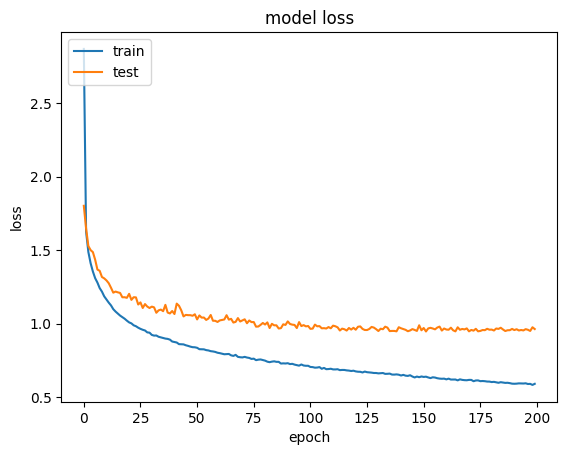

In [11]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

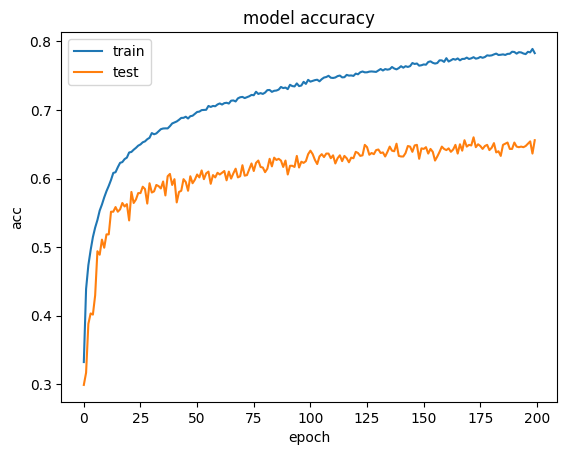

In [12]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
loss, acc = model.evaluate(X_test_cnn, y_test_e_cnn)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

37/37 [==============================] - 1s 16ms/step - loss: 0.9627 - accuracy: 0.6559
Restored model, accuracy: 65.59%


In [14]:
# model_1 = 'T2-1-0328-aug-t1-r4' + '-' +str(acc)
acc2 = acc * 10000
acc_formatted = '{:04d}'.format(int(acc2))
model_1 = 'T2-1-0328-aug-t3' + '-' + acc_formatted
# model_2 = 'T2-2-0320-aug-v3d4-v3r2'
model_name = model_1 + '.h5'
save_dir = './CNN1-models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


# model_name = model_2 + '.h5'
# save_dir = './CNN2-models'
# # Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model2.save(model_path)
# print('Saved trained model at %s ' % model_path)

Saved trained model at ./CNN1-models/T2-1-0328-aug-t3-6559.h5 


In [15]:
from google.colab import runtime
runtime.unassign()